In [3]:
import pandas as pd
import numpy as np
import os

In [5]:
df = pd.read_csv('./final_stats/final_season_sent_game_last_1.csv', index_col=[0])
df = df.reset_index(drop=True)
for col in df.columns:
    print(col)

Week
Day
Date
home
away
home_score
away_score
away_positive96
away_positive24
away_neutral96
away_neutral24
away_negative96
away_negative24
away_sentiment_96h
away_sentiment_24h
away_swing
home_positive96
home_positive24
home_neutral96
home_neutral24
home_negative96
home_negative24
home_sentiment_96h
home_sentiment_24h
home_swing
home_score_team
home_score_opp
home_pass_cmp_off
home_pass_att_off
home_pass_yds_off
home_pass_tds_off
home_sacks_off
home_sacks_yds_off
home_pass_qb_rate
home_rush_att_off
home_rush_yds_off
home_rush_tds_off
home_3d_made
home_3d_att
home_time_poss
home_1st_down_off
home_turnover_off
home_1st_down_def
home_tot_yds_def
home_pass_yds_def
home_rush_yds_def
home_turnover_def
home_exp_def
home_def_rush_att
home_def_rush_tds
home_off_rush_att
home_off_rush_tds
home_def_pass_cmp
home_def_pass_att
home_def_pass_tds
home_def_pass_ints
home_off_pass_cmp
home_def_sacks
home_def_sack_yds
home_tm_penalty
home_tm_penalty_yds
home_opp_penalty
home_opp_penalty_yds
home_spread

### Drop unused columns
### No sentiment model

Remove all neutral metrics
Remove week, date, home spread, spread from last games. ...............



In [6]:
# always remove
cols_remove_always = [
    'Week',
    'Date',
    'home_spread',
    # 'away_spread',
    'away_neutral96',
    'away_neutral24',
    'home_neutral96',
    'home_neutral24',
]

# cols to remove for no sentiment

cols_remove_no_sentiment = [
    'away_positive96',
    'away_positive24',
    'away_negative96',
    'away_negative24',
    'away_sentiment_96h',
    'away_sentiment_24h',
    'away_swing',

    'home_positive96',
    'home_positive24',
    'home_negative96',
    'home_negative24',
    'home_sentiment_96h',
    'home_sentiment_24h', 
    'home_swing',
]

# cols to remove for 96 hour sentiment
cols_remove_96_sentiment = [
    'away_positive24',
    'away_negative24',
    'away_sentiment_24h',
    'away_swing',

    'home_positive24',
    'home_negative24',
    'home_sentiment_24h', 
    'home_swing',
]

# cols to remove for 24 hour sentiment
cols_remove_24_sentiment = [
    'away_positive96',
    'away_negative96',
    'away_sentiment_96h',
    'away_swing',

    'home_positive96',
    'home_negative96',
    'home_sentiment_96h',
    'home_swing',
]

# sentiment to remove for cross
cols_remove_crcoss_sentiment= [
    'away_positive96',
    'away_positive24',
    'away_negative96',
    'away_negative24',
    'away_sentiment_96h',
    'away_sentiment_24h',

    'home_positive96',
    'home_positive24',
    'home_negative96',
    'home_negative24',
    'home_sentiment_96h',
    'home_sentiment_24h', 
]

In [7]:
print(len(cols_remove_always))
print(len(cols_remove_no_sentiment))
print(len(cols_remove_96_sentiment))
print(len(cols_remove_24_sentiment))
print(len(cols_remove_crcoss_sentiment))

7
14
8
8
12


## one-hot encode teams

In [8]:
def one_hot_encode_teams_days(df):
    df_1hot_home = pd.get_dummies(df.home, prefix='home', drop_first=True)
    df_1hot_away = pd.get_dummies(df.away, prefix='away', drop_first=True)
    df_1hot_days = pd.get_dummies(df.Day, prefix='day', drop_first=True)
    return pd.concat([df, df_1hot_home, df_1hot_away,df_1hot_days], axis=1).drop(['home','away', 'Day'], axis=1)

# df_1hot = one_hot_encode_teams_days(df_no_sent)
# df_1hot.head()

In [9]:
def move_away_spread_to_start(df):
    spread_col = df.pop('away_spread')
    # df = pd.concat([spread_col, df])
    df.insert(0, 'away_spread', spread_col)
    return df

# df_1hot1 = move_away_spread_to_start(df_1hot)
# df_1hot1['away_spread'].mean()
# df_1hot1.tail(10)


In [10]:
def find_spread_ties(df):
    df = df.copy()
    df['away_tie'] = df['away_score'] + df['away_spread'] == df['home_score']
    return df.index[df['away_tie']].tolist()


Find one "push" where there is no winner with the spread, teams tied with the spread. 
Game 96 in list. Remove 

In [11]:
def remove_tied_spread_games(df):
    index_to_remove = find_spread_ties(df)
    # print('Rows to remove: ', index_to_remove)
    df = df.drop(index_to_remove, axis=0)
    return df

# df_no_ties = remove_tied_spread_games(df_1hot1)


### Create binary target "Away Winner With The Spread (wts)"
Binary Value true or false

In [12]:
def create_winner_with_the_spread_col(df):
    df = df.copy()
    df['away_winner_wts'] = df['away_score'] + df['away_spread'] > df['home_score']
    # convert to 0 1
    df['away_winner_wts'] = df['away_winner_wts'].astype(int)
    col_to_move = df.pop('away_winner_wts')
    df.insert(0, 'away_winner_wts', col_to_move)
    df = df.drop(['home_score','away_score'], axis=1)
    return df

### Create binary target "Away Winner or Loser Straight up"
Binary Value true or false

In [13]:
# df11 = convert_actual_spread_to_winner_wts(df_1hot1)
def create_winner_straight_up_col(df):
    df = df.copy()
    df['away_winner_stup'] = df['away_score'] > df['home_score']
    # convert to 0 1
    df['away_winner_stup'] = df['away_winner_stup'].astype(int)
    col_to_move = df.pop('away_winner_stup')
    df.insert(0, 'away_winner_stup', col_to_move)
    df = df.drop(['home_score','away_score'], axis=1)
    return df

#### this is for getting the actual spread rather than a winner with the spread target

In [14]:
def combine_score_to_spread_result(df):
    df = df.copy()
    df['away_actual_spread'] = df['home_score'] - df['away_score']
    col_to_move = df.pop('away_actual_spread')
    df.insert(0, 'away_actual_spread', col_to_move)
    df = df.drop(['home_score','away_score'], axis=1)
    return df

# combine_score_to_spread_result(df_1hot1)

### Combine Previous Preprocessing

In [15]:
# create winner wts
def preprocess_1(filepath, cols1, cols2):
    # read csvw
    df = pd.read_csv(filepath, index_col=[0])
    df = df.reset_index(drop=True)
    # drop correct columns
    print('# cols to remove: ', len(cols1)+len(cols2))
    df2 = df.drop(cols1, axis=1)
    df2 = df2.drop(cols2, axis=1)
    print('# cols removed: ', df.shape[1] - df2.shape[1] )
    if len(cols1) + len(cols2) != df.shape[1] - df2.shape[1]:
        print("ERROR: Wrong number of columns removed")
    # one-hot encode categorical vars
    df2 = one_hot_encode_teams_days(df2)
    # remove pushed or tied spread games
    df2 = remove_tied_spread_games(df2)
    # move away_spread to first col
    # df2 = move_away_spread_to_start(df2)
    # create binary target away winner wts column
    df2 = create_winner_with_the_spread_col(df2)
    return df2

# create winner straight up
def preprocess_2(filepath, cols1, cols2):
    # read csvw
    df = pd.read_csv(filepath, index_col=[0])
    df = df.reset_index(drop=True)
    # drop correct columns
    print('# cols to remove: ', len(cols1)+len(cols2))
    df2 = df.drop(cols1, axis=1)
    df2 = df2.drop(cols2, axis=1)
    print('# cols removed: ', df.shape[1] - df2.shape[1] )
    if len(cols1) + len(cols2) != df.shape[1] - df2.shape[1]:
        print("ERROR: Wrong number of columns removed")
    # one-hot encode categorical vars
    df2 = one_hot_encode_teams_days(df2)
    # remove pushed or tied spread games
    df2 = remove_tied_spread_games(df2)
    # move away_spread to first col
    # df2 = move_away_spread_to_start(df2)
    # create binary target away winner wts column
    df2 = create_winner_straight_up_col(df2)
    return df2


In [16]:
filepath1 = './final_stats/final_season_sent_game_last_1.csv'    
filepath3 = './final_stats/final_season_sent_game_last_3.csv'    
filepath7 = './final_stats/final_season_sent_game_last_7.csv'    
filepathssn = './final_stats/final_season_sent_game_last_ssn.csv'    
filepath3wt = './final_stats/final_season_sent_game_last_3_wt.csv'    
filepath7wt = './final_stats/final_season_sent_game_last_7_wt.csv'    
filepathssnwt = './final_stats/final_season_sent_game_last_ssn_wt.csv'    

filepaths = [
    ['last_1', filepath1 ],
    ['last_3', filepath3],
    ['last_7', filepath7],
    ['last_ssn', filepathssn],
    ['last_3_wt', filepath3wt],
    ['last_7_wt', filepath7wt],
    ['last_ssn_wt', filepathssnwt],

]

columns = [
    ['no_sent' , cols_remove_no_sentiment],
    ['sent_96' , cols_remove_96_sentiment],
    ['sent_24' , cols_remove_24_sentiment],
    ['sent_cross' , cols_remove_crcoss_sentiment],
]

In [17]:
df = pd.read_csv('./final_stats/final_season_sent_game_last_1.csv', index_col=[0])
df['away_spread']

0    -1.5
1    -3.0
2    14.0
3     4.0
4    -1.0
     ... 
1    -2.5
2    13.5
3     3.0
4     8.5
5    -2.5
Name: away_spread, Length: 106, dtype: float64

In [48]:
df_1 = preprocess_1(filepath3, columns[2][1], cols_remove_always)
df_1.head()


# cols to remove:  15
# cols removed:  15


,away_winner_wts,away_positive24,away_negative24,away_sentiment_24h,home_positive24,home_negative24,home_sentiment_24h,home_score_team,home_score_opp,home_pass_cmp_off,...,away_ravens,away_saints,away_seahawks,away_steelers,away_texans,away_titans,away_vikings,day_Sat,day_Sun,day_Thu
0,1,340.0,43.0,0.368944,187.0,56.0,0.247637,20.333333,15.666667,16.000000,...,0,0,0,0,0,0,0,0,1,0
1,0,186.0,23.0,0.355120,356.0,195.0,0.149351,24.000000,27.666667,22.333333,...,0,0,0,0,0,0,0,0,1,0
2,0,129.0,25.0,0.283379,1019.0,66.0,0.657241,35.000000,25.333333,25.333333,...,0,0,0,0,1,0,0,0,1,0
3,0,80.0,24.0,0.183007,262.0,82.0,0.274809,24.000000,17.000000,15.666667,...,0,0,0,0,0,0,0,0,1,0
4,0,197.0,42.0,0.322917,38.0,9.0,0.276190,16.333333,23.333333,16.000000,...,0,0,0,0,0,0,0,0,1,0


## Look to seperate favorites and underdog winners and such
Need moneyline for straight up bets

https://www.oddsportal.com/american-football/usa/nfl/results/

In [19]:
def save_all_datasets(filepaths, columns, cols_always_remove):
    for x in filepaths:
        key_file = x[0]
        filepath = x[1]
        for y in columns:
            key_col = y[0]
            cols = y[1]
            df = preprocess_1(filepath, cols, cols_always_remove)
            save_file_name = f'preprocessed_{key_col}_{key_file}.csv'
            df.to_csv(f'./final_stats/preprocessed_3/{save_file_name}')
            

In [ ]:
save_all_datasets(filepaths, columns, cols_remove_always)

## Predict the away actual spread

In [ ]:
df_test = pd.read_csv()

In [52]:
def split_target(df, target_col='away_winner_wts'):
    df = df.copy()
    target = df.pop(target_col)
    return df, target

Balanced dataset, 53 home winners wts and 52 away winners with the spread


## Normailze all columns


In [1]:
from sklearn.preprocessing import StandardScaler

def normalize_df(df):
    data, target = split_target(df)
    scaler = StandardScaler()
    data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    return data, target

data,target = normalize_df(df_1)


NameError: name 'df_1' is not defined

In [54]:
target

0      1.009570
1     -0.990521
2     -0.990521
3     -0.990521
4     -0.990521
         ...   
100   -0.990521
101    1.009570
102    1.009570
103    1.009570
104    1.009570
Name: away_winner_wts, Length: 105, dtype: float64

In [55]:
import tensorflow as tf

c:\Users\hugho\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [56]:
# normalizer = tf.keras.layers.Normalization(axis=-1)

def get_basic_model():
    model = tf.keras.Sequential([
        # normalizer,
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy'])
    
    return model
    

In [57]:
model = get_basic_model()
history = model.fit(data, target, epochs=50, validation_split=0.2)

Epoch 1/50
3/3 [==============================] - 1s 116ms/step - loss: -0.0301 - accuracy: 0.0000e+00 - val_loss: 2.3506 - val_accuracy: 0.0000e+00
Epoch 2/50
3/3 [==============================] - 0s 15ms/step - loss: -0.5876 - accuracy: 0.0000e+00 - val_loss: 2.3506 - val_accuracy: 0.0000e+00
Epoch 3/50
3/3 [==============================] - 0s 17ms/step - loss: -0.5876 - accuracy: 0.0000e+00 - val_loss: 2.3506 - val_accuracy: 0.0000e+00
Epoch 4/50
3/3 [==============================] - 0s 22ms/step - loss: -0.5876 - accuracy: 0.0000e+00 - val_loss: 2.3506 - val_accuracy: 0.0000e+00
Epoch 5/50
3/3 [==============================] - 0s 17ms/step - loss: -0.5876 - accuracy: 0.0000e+00 - val_loss: 2.3506 - val_accuracy: 0.0000e+00
Epoch 6/50
3/3 [==============================] - 0s 27ms/step - loss: -0.5876 - accuracy: 0.0000e+00 - val_loss: 2.3506 - val_accuracy: 0.0000e+00
Epoch 7/50
3/3 [==============================] - 0s 17ms/step - loss: -0.5876 - accuracy: 0.0000e+00 - val_los

In [58]:
import matplotlib.pyplot as plt

def plot_train_val_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.plot(epochs, loss, blue_dots, label = 'Training loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def plot_train_val_acc(history):
    plt.clf()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
        
    epochs = range(1, len(acc) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
        
    plt.plot(epochs, acc, blue_dots, label = 'Training Accuracy')
    plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation Accuracy')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

def plot_train_val_loss_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)
    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    # plt.plot(epochs_range, acc, label='Training Accuracy')
    # plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    
 
    plt.plot(epochs_range, acc, blue_dots, label = 'Training Accuracy')
    plt.plot(epochs_range, val_acc, solid_blue_line, label = 'Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, blue_dots, label='Training Loss')
    plt.plot(epochs_range, val_loss, solid_blue_line, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
  
def compare_loss(hist1, hist2, title1, title2): 
    min_epochs = min(len(hist1.history['loss']), len(hist2.history['loss']))
    loss = hist1.history['loss'][:min_epochs]
    val_loss = hist1.history['val_loss'][:min_epochs]
    loss_drop = hist2.history['loss'][:min_epochs]
    val_loss_drop = hist2.history['val_loss'][:min_epochs]

    epochs = range(1, min_epochs + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    plt.plot(epochs, loss, blue_dots, label = f'{title1} Training Loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = f'{title1} Validation Loss')
    plt.plot(epochs, loss_drop, red_dots, label = f'{title2} Training Loss')
    plt.plot(epochs, val_loss_drop, solid_red_line, label = f'{title2} Validation Loss')
    # plt.title('Loss With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def compare_acc(hist1, hist2, title1, title2): 
    min_epochs = min(len(hist1.history['accuracy']), len(hist2.history['accuracy']))
    acc = hist1.history['accuracy'][:min_epochs]
    val_acc = hist1.history['val_accuracy'][:min_epochs]
    acc_drop = hist2.history['accuracy'][:min_epochs]
    val_acc_drop = hist2.history['val_accuracy'][:min_epochs]
    
    epochs = range(1, min_epochs + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    plt.plot(epochs, acc, blue_dots, label = f'{title1} Training Accuracy')
    plt.plot(epochs, val_acc, solid_blue_line, label = f'{title1} Validation Accuracy')
    plt.plot(epochs, acc_drop, red_dots, label = f'{title2} Training Accuracy')
    plt.plot(epochs, val_acc_drop, solid_red_line, label = f'{title2} Validation Accuracy')
    # plt.title('Accuracy With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

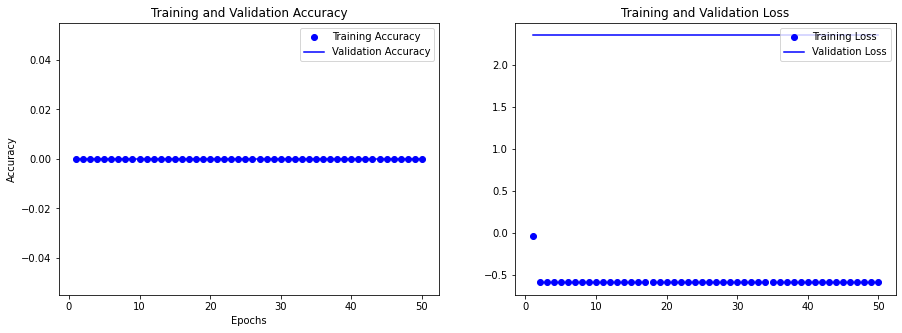

In [59]:
plot_train_val_loss_acc(history)